## Get indices for regions from INALT20

## Tech preamble

In [1]:
import dask
import os
import datetime
import xorca_box as xbox
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy as ccrs
from pathlib import Path
from matplotlib import pyplot as plt
from xorca.lib import load_xorca_dataset

## Dask client

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:30:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37869 instead
  warnings.warn(


In [3]:
from dask.distributed import Client

In [4]:
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9,
#                local_directory=os.environ["TMPDIR"])
client = Client(cluster)
client

Client Scheduler: tcp://172.18.4.13:45851 Dashboard: http://172.18.4.13:37869/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
    target_duration="360s",
)

## Parameter preamble

In [6]:
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 23
chu_t = 1

## Find data files

In [7]:
MESH_MASK_files = list(sorted(
    (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files")

Found 1 mesh/mask files


## Load model data

In [8]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            MESH_MASK_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})
ds_mesh.coords['y']=ds_mesh.y
ds_mesh.coords['x']=ds_mesh.x

In [9]:
def getij_moor(ds_mesh,grid,latlim,lonlim):
    
    if grid=="T":
        lat,lon = ds_mesh.gphit.squeeze(),ds_mesh.glamt.squeeze()
    elif grid=="U":
        lat,lon = ds_mesh.gphiu.squeeze(),ds_mesh.glamu.squeeze()
    elif grid=="V":
        lat,lon = ds_mesh.gphiv.squeeze(),ds_mesh.glamv.squeeze()

    if grid=="T":
        cond = ((latlim[0]<=ds_mesh.gphit)&
                (ds_mesh.gphit<=latlim[1])&
                (lonlim[0]<=ds_mesh.glamt)&
                (ds_mesh.glamt<lonlim[1])
               )
    elif grid=="U":
        cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<=latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<=lonlim[1]))
    elif grid=="V":
        cond = ((latlim[0]<=ds_mesh.gphiv) &
                       (ds_mesh.gphiv<=latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamv) &
                       (ds_mesh.glamv<=lonlim[1]))
#     print(cond)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

### Region 2

In [10]:
RTEB1_lat = [-10,10] 
RTEB1_lon = [-65,15]

latidx,lonidx = getij_moor(ds_mesh,'T',RTEB1_lat,RTEB1_lon)
print(latidx[[0,-1]].values,lonidx[[0,-1]].values)

[1428 1830] [  89 1688]


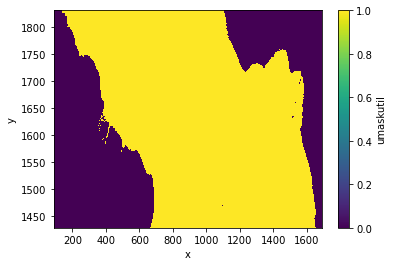

In [11]:
ds_mesh.umaskutil.sel(x=lonidx,y=latidx).squeeze().plot()

In [12]:
fn='/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_taux_tauy_10S10N/1_INALT20.L46-KFS044_5d_19580101_19581231_windstress_10S10N_65W15E_grid_V.nc'
ds = xr.open_dataset(fn)
display(ds)

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 73, x: 1601, y: 403)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1958-01-03 12:00:00 ... 1958-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    sometauy              (time_counter, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
Attributes:
    name:                      1_INALT20.L46-KFS044_5d_19580101_19581231
    description:               ocean V grid variables
    title:                     ocean V grid variables
    Conventions:               CF-1.5
    production:                An IPSL model
    timeStamp:                 2016-Dec-23 17:01:48 CET
    NCO:                       netCDF Operators version 4.9.3 (Homepage = htt...
    nco_openmp_thread_number:  1
    history:                   Wed Sep 28 13:29:43 2022: ncatted -O -a pi,glo...
    pi:                        Arne Biastoch
    pi_email:                  abiastoch@geomar.de
    experiment_name:           $CONF
    experiment_id:             $CASE
    institution_id:            GEOMAR
    institution:               GEOMAR Helmholtz Centre for Ocean Research
    contributor_name:          Klaus Getzlaff, \n Franziska schwarzkopf,
    contributor_email:         kgetzlaff@geomar.de, \n fschwarzkopf@geomar.de,
    creator_name:              Kristin Burmeister
    creator_email:             kristin.burmeister@sams.ac.uk, ORCID 0000-0003...
    license:                   CC-BY4
    keywords:                  Atlantic, ocean-model, high-resolution, temper...
    reference:                 Schwarzkopf et al., 2019, https://doi.org/10.5...
    terms_of_use:              By using the given data the following terms an...

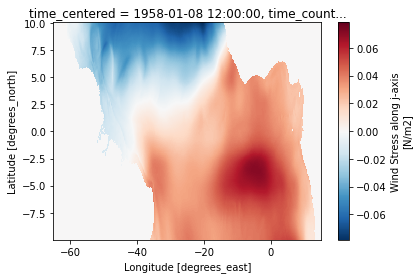

In [13]:
ds.sometauy.isel(time_counter=1).plot(y='nav_lat',x='nav_lon')

## 35W

In [14]:
lonlim = [-35.2, -34.8]
latlim = [-6,10]

latidx,lonidx = getij_moor(ds_mesh,'T',latlim,lonlim)
print(latidx[[0,-1]].values,lonidx[[0,-1]].values)

[1509 1830] [685 692]


6°N/S sections

[1509 1510] [ 669 1638]


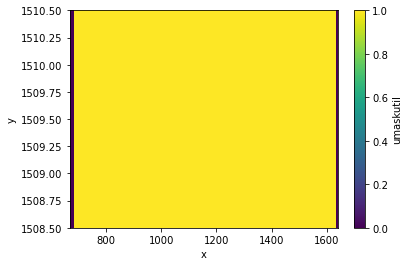

In [34]:
lonlim = [-36,12.5]
latlim = [-6,-5.9]

latidx,lonidx = getij_moor(ds_mesh,'T',latlim,lonlim)
print(latidx[[0,-1]].values,lonidx[[0,-1]].values)

ds_mesh.umaskutil.sel(x=lonidx,y=latidx).squeeze().plot()

[1748 1749] [ 281 1188]


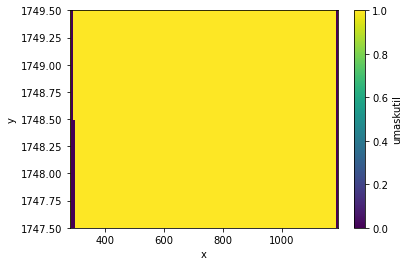

In [29]:
lonlim = [-55.4,-10]
latlim = [5.9,6]

latidx,lonidx = getij_moor(ds_mesh,'T',latlim,lonlim)
print(latidx[[0,-1]].values,lonidx[[0,-1]].values)
ds_mesh.umaskutil.sel(x=lonidx,y=latidx).squeeze().plot()